In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Clim_data/df_eddies_processed.pkl')


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))


In [3]:
dataset.variables['ocean_time']


<class 'netCDF4._netCDF4.Variable'>
float64 ocean_time(ocean_time)
    long_name: averaged time since initialization
    units: seconds since 1990-01-01 00:00:00
    calendar: proleptic_gregorian
    field: time, scalar, series
unlimited dimensions: ocean_time
current shape = (30,)
filling on, default _FillValue of 9.969209968386869e+36 used

5 year Dataset i.e. starting from the second year.


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
6190,1828,139,CE,157.059283,-31.185958,202,217,604.463444,1070.031206,-0.015698,0.005227,-0.005541,-0.042479,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
6191,1829,139,CE,157.078842,-31.142351,202,218,604.826448,1075.256459,-0.014436,0.004031,-0.005326,-0.039524,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
6192,1830,139,CE,157.124214,-31.078168,202,219,606.871022,1083.491221,-0.010992,0.002657,-0.004730,-0.031444,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
6193,1831,139,CE,157.185960,-31.002953,203,221,610.051900,1093.424471,-0.008855,0.001169,-0.004493,-0.026696,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
6194,1832,139,CE,157.244347,-30.967634,204,223,614.225702,1099.054308,-0.008279,0.000785,-0.004631,-0.025818,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30571,3646,661,CE,152.918833,-38.395610,171,37,476.237996,183.017279,-0.003693,0.002256,-0.006219,-0.019825,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
30572,3647,661,CE,152.971481,-38.375238,172,38,479.971110,186.729214,-0.004736,0.002579,-0.005423,-0.020319,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
30573,3648,661,CE,153.053559,-38.364292,174,39,486.464553,190.334431,-0.005506,0.003351,-0.005385,-0.021782,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
30574,3649,661,CE,153.169057,-38.316516,176,40,494.571680,198.807592,-0.006269,0.003703,-0.005896,-0.024331,25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


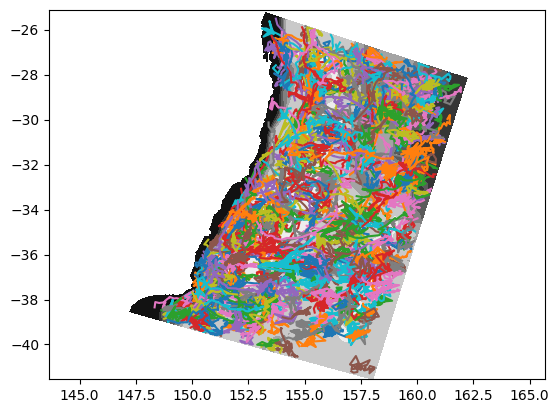

In [4]:
valid_eddies = []
for eddy in df_eddies.ID.unique():
    df = df_eddies[df_eddies.ID == eddy]
    if np.all((df.Day >= 1827) & (df.Day <= 3652)):
        valid_eddies.append(eddy)
df_5yr_eddies = df_eddies[df_eddies.ID.isin(valid_eddies)]
plt.contourf(lon_rho, lat_rho, np.where(mask_rho, h, np.nan)/1000, cmap='grey')
for eddy in df_5yr_eddies.ID.unique():
    df = df_5yr_eddies[df_5yr_eddies.ID==eddy]
    plt.plot(df.Lon, df.Lat)
plt.axis('equal')
df_5yr_eddies


Calculate there vertical centers

In [5]:
def create_vertical_dataset(df_eddies, eddy, X, Y, z_r, r=30):

    df = df_eddies[df_eddies['ID'] == eddy].copy()
    dic_tilt = {f'Eddy{eddy}': {}}
    fnumber_old = None
    x, y = X[:,0], Y[0,:]
    timer = 0

    for t, data in df.iterrows():
        day, fname, xc_surf, yc_surf, w_surf = data['Day'], data['fname'], data['x0'], data['y0'], data['w']
        fnumber = fname[-8:-3]

        # Only load if file changes
        if fnumber != fnumber_old:
            u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
            v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
            u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
            v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
            with nc.Dataset(fname) as dataset:
                ocean_time = dataset.variables['ocean_time'][:].data / 86400
            fnumber_old = fnumber
        t_rel = np.where(ocean_time == day)[0][0]

        u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

        df_tilt = []
        x0, y0 = xc_surf, yc_surf
        x0_old, y0_old = xc_surf, yc_surf

        # for k in range(24):
        for k in range(u_t.shape[-1]):
            u, v = u_t[:, :, k], v_t[:, :, k]

            R_grid = np.hypot(x0 - X, y0 - Y)
            ic, jc = map(int, np.unravel_index(np.argmin(R_grid), R_grid.shape))

            margin = 5 # DOPIOE wont work if too close to boundary
            if (ic < margin or ic >= X_grid.shape[0] - margin or
                jc < margin or jc >= X_grid.shape[1] - margin):
                break

            # horizontal transect (constant y = y[jc])
            x_mask = np.abs(x - x0) < r
            x1 = x[x_mask]
            y1 = np.full_like(x1, y[jc])
            u1 = u[x_mask, jc]
            v1 = v[x_mask, jc]
        
            # vertical transect (constant x = x[ic])
            y_mask = np.abs(y - y0) < r
            y2 = y[y_mask]
            x2 = np.full_like(y2, x[ic])
            u2 = u[ic, y_mask]
            v2 = v[ic, y_mask]

            x0, y0, w, Q, Rc, psi0 = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)

            if (np.sign(w) != np.sign(w_surf)) or (np.hypot(x0_old - x0, y0_old - y0) > 50):
                break
            else:
                x0_old, y0_old = x0, y0

            df_tilt.append({
                'x': x0, 'y': y0, 'Q': Q, 'w': w,
                'Rc': Rc, 'psi0': psi0,
                'z': k, 'Depth': z_r[k]
            })

        if df_tilt:
            df_tilt = pd.DataFrame(df_tilt)
            dx = df_tilt['x'].diff()
            dy = df_tilt['y'].diff()
            df_tilt['TD'] = np.hypot(df_tilt['x'] - df_tilt.iloc[0]['x'],
                                  df_tilt['y'] - df_tilt.iloc[0]['y'])
            dic_tilt[f'Eddy{eddy}'][f'Day{day}'] = df_tilt
        else:
            dic_tilt[f'Eddy{eddy}'][f'Day{day}'] = pd.DataFrame(columns=['x', 'y', 'Q', 'w', 'Rc', 'psi0', 'z','Depth'])
        
    return dic_tilt
    


In [6]:
# dic_5yr = {}
# for e, eddy in enumerate(df_5yr_eddies.ID.unique()):
#     dic = create_vertical_dataset(df_eddies, eddy, X_grid, Y_grid, z_r)
#     dic_5yr = dic_5yr | dic 
#     print(f'{e}/{len(df_5yr_eddies.ID.unique())}')

# with open('/srv/scratch/z5297792/Clim_data/year_tests/dic_5year_1827_3652_vert_info.pkl', 'wb') as f:
#     pickle.dump(dic_5yr, f)

#######################################################################################################
# with open('/srv/scratch/z5297792/Clim_data/year_tests/dic_1year_1827_2192_vert_info.pkl', 'rb') as f:
#     dic_1yr = pickle.load(f)

with open('/srv/scratch/z5297792/Clim_data/year_tests/dic_5year_1827_3652_vert_info.pkl', 'rb') as f:
    dic_5yr = pickle.load(f)
    

In [7]:
def bearing(a, b):
    dx = b[0] - a[0]
    dy = b[1] - a[1]
    angle_rad = np.arctan2(dx, dy)  # note the order: dx, dy
    angle_deg = np.degrees(angle_rad)
    bearing = (angle_deg + 360) % 360
    return bearing

def compute_tilt_data(dic, eddy, num=6, depth_int=10, max_depth=1000):
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'Tilt Dis', 'Tilt Dir'])
    
    diffs_x = {}
    diffs_y = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()

        if len(df):
        
            depths       = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values)
            y_i = np.interp(valid, depths, df['y'].values)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # delta = np.hypot(dx, dy)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
        
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

        else:
            idx = [10]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    for ref_day in range(num //2, len(dic) - num //2):
    
        df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
        df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
        
        # Calculation of variability at each depth
        df_data = pd.DataFrame()
        df_data[r'$\Delta x$'] = df_X.mean(axis=1)
        df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
        df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
        df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
        df_data[r'$\sigma^2_{\Delta x}$'] = df_X.std(axis=1)
        df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.std(axis=1)
        df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
        df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
        df_data['Depth'] = df_data.index 
        df_data
        
        # Line of Best Fit
        
        # your data arrays of shape (N,)
        x = df_data[r'$\sum{\Delta x}$'].values
        y = df_data[r'$\sum{\Delta y}$'].values
        z = df_data['Depth'].values
        w = df_data['weight'].values
        
        # 1. compute weighted mean
        W = np.sum(w)
        mean = np.array([np.dot(w, x),
                         np.dot(w, y),
                         np.dot(w, z)]) / W
        
        # 2. center and weight the data
        X = np.vstack((x, y, z)).T
        Xc = X - mean
        Xw = Xc * np.sqrt(w)[:, None]
        
        # 3. SVD on weighted, centered data
        try:
            flag = 0
            _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
        except Exception:
            flag = 1
            # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
            
        if flag:
            
            df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': list(dic.keys())[ref_day][3:], 'Tilt Dis': np.nan, 'Tilt Dir': np.nan}
            
        else:
            
            direction = Vt[0]   # principal axis
            
            # The best-fit line is:  p(t) = mean + t * direction
            t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
            p = mean[None, :] + t[:, None] * direction  # shape (100,3)
            # or equivalently
            p = mean + np.outer(t, direction)          # also (100,3)
            
            # then split back out if you need x,y,z separately:
            x_line, y_line, z_line = p.T
            
            tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
            
            top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
            if top_idx == 1:
                btm_idx = 0
            else:
                btm_idx = 1
            top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
            btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
            tilt_direc = ( bearing(btm, top) + 20 ) % 360
        
            df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': list(dic.keys())[ref_day][3:], 'Tilt Dis': tilt_dist, 'Tilt Dir': tilt_direc}
        
    df_tilt_data['Day'] = df_tilt_data['Day'].astype(int)
        
    return df_tilt_data


In [8]:
for e, eddy in enumerate(dic_5yr.keys()):
    dic = dic_5yr[eddy]
    df = compute_tilt_data(dic, int(eddy[4:]))
    if e == 0:
        df_tilt_data = df
    else:
        df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
df_tilt_data


,Eddy,Day,Tilt Dis,Tilt Dir
0,139,1831,5.450166,281.862892
1,139,1832,3.148655,265.515548
2,139,1833,2.420232,211.183734
3,139,1834,3.824071,181.167664
4,139,1835,5.460166,175.806031
...,...,...,...,...
20995,661,3643,1.193491,140.959569
20996,661,3644,1.959289,202.305224
20997,661,3645,2.123659,232.532911
20998,661,3646,4.167315,239.219567


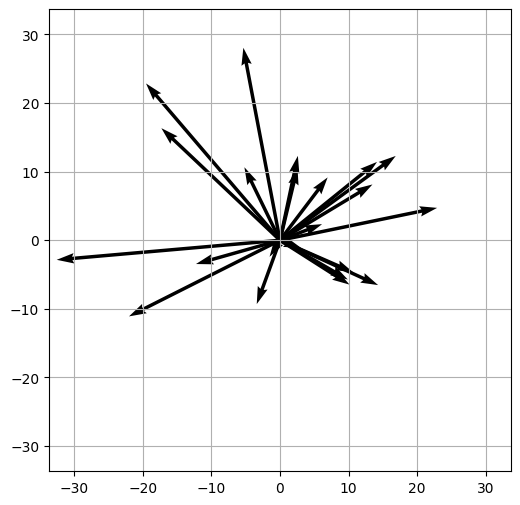

In [9]:
df = df_tilt_data[df_tilt_data.Eddy==237].copy().dropna()

r = df['Tilt Dis'].values
theta = df['Tilt Dir'].values

u = r * np.cos(theta)  # x-component
v = r * np.sin(theta)  # y-component

# Plot quiver from the origin (0, 0)
plt.figure(figsize=(6, 6))
plt.quiver(np.zeros_like(r), np.zeros_like(r), u, v, angles='xy', scale_units='xy', scale=1)
plt.xlim(-max(r)-1, max(r)+1)
plt.ylim(-max(r)-1, max(r)+1)
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()


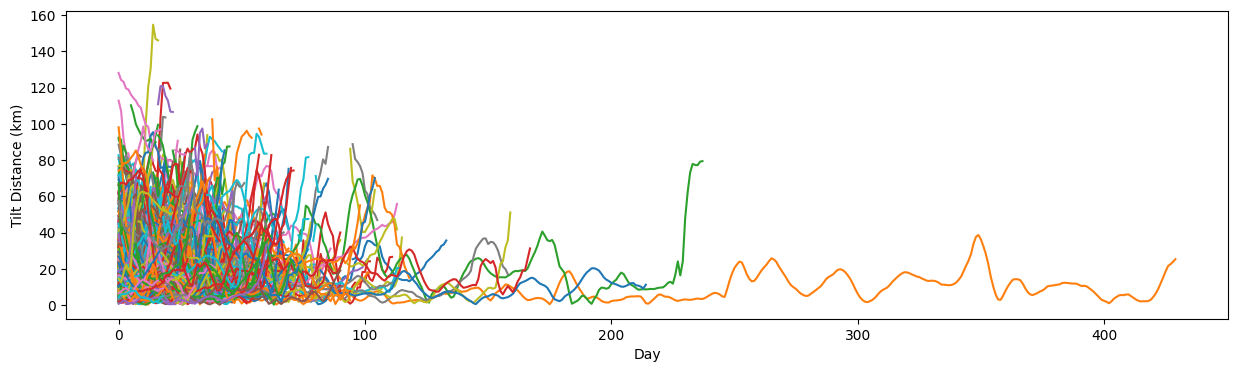

In [10]:
plt.figure(figsize=(15,4))
for eddy in df_tilt_data.Eddy.unique():
    df = df_tilt_data[df_tilt_data.Eddy==eddy]
    plt.plot(np.arange(len(df)), df['Tilt Dis'])
    plt.xlabel('Day')
    plt.ylabel('Tilt Distance (km)')
    

In [17]:
lons, lats, cycs = [], [], []
for k in range(len(df_tilt_data)):
    row = df_tilt_data.iloc[k]
    eddy, day = row.Eddy, row.Day
    data = df_eddies[(df_eddies.ID==eddy) & (df_eddies.Day==day)].iloc[0]
    lons.append(data.Lon)
    lats.append(data.Lat)
    cycs.append(data.Cyc)
df_tilt_data['Lon'] = lons
df_tilt_data['Lat'] = lats
df_tilt_data['Cyc'] = cycs
df_tilt_data


,Eddy,Day,Tilt Dis,Tilt Dir,Lon,Lat,Cyc
0,139,1831,5.450166,281.862892,157.185960,-31.002953,CE
1,139,1832,3.148655,265.515548,157.244347,-30.967634,CE
2,139,1833,2.420232,211.183734,157.283430,-30.739701,CE
3,139,1834,3.824071,181.167664,157.221638,-30.729138,CE
4,139,1835,5.460166,175.806031,157.170389,-30.685034,CE
...,...,...,...,...,...,...,...
20995,661,3643,1.193491,140.959569,152.491051,-38.531719,CE
20996,661,3644,1.959289,202.305224,152.750739,-38.406086,CE
20997,661,3645,2.123659,232.532911,152.862284,-38.396935,CE
20998,661,3646,4.167315,239.219567,152.918833,-38.395610,CE


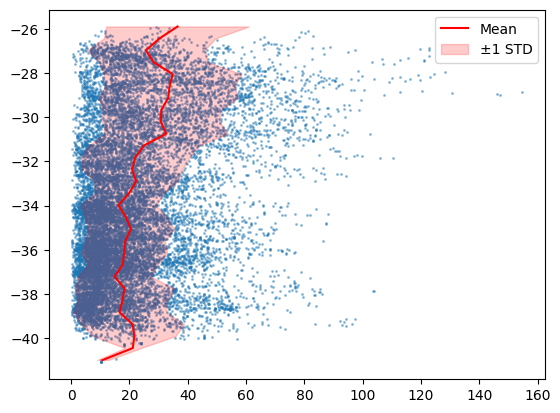

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x = df_tilt_data['Tilt Dis']
y = df_tilt_data['Lat']

# Bin by y (latitude)
bins = np.linspace(y.min(), y.max(), 30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
digitized = np.digitize(y, bins)

# Compute mean and std of x in each y-bin
mean = [x[digitized == i].mean() for i in range(1, len(bins))]
std = [x[digitized == i].std() for i in range(1, len(bins))]

# Plot
plt.scatter(x, y, marker='.', s=5, alpha=0.4)
plt.plot(mean, bin_centers, color='red', label='Mean')
plt.fill_betweenx(bin_centers,
                  np.array(mean) - np.array(std),
                  np.array(mean) + np.array(std),
                  color='red', alpha=0.2, label='±1 STD')
plt.legend()


(np.float64(146.3614666726723),
 np.float64(162.6091998738818),
 np.float64(-41.897597214082765),
 np.float64(-24.318669960665034))

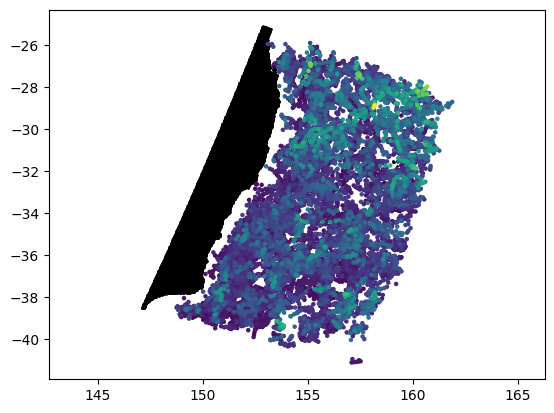

In [51]:
mask = mask_rho == 0
df = df_tilt_data.copy()
df = df.sort_values(by='Tilt Dis').reset_index(drop=True)
plt.scatter(lon_rho[mask],lat_rho[mask], color='k', s=1)
plt.scatter(df.Lon, df.Lat, c=df['Tilt Dis'], s=5)
plt.axis('equal')

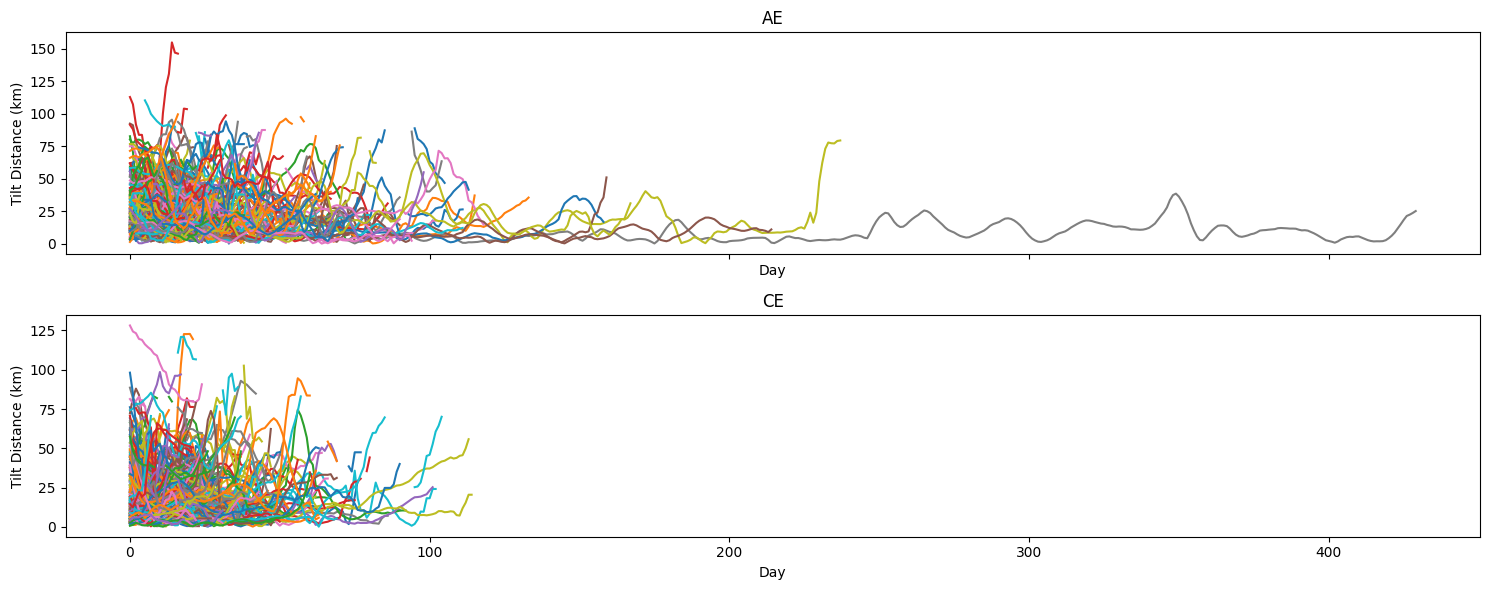

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
for eddy in df_tilt_data.Eddy.unique():
    df = df_tilt_data[df_tilt_data.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        axs[0].plot(np.arange(len(df)), df['Tilt Dis'])
        axs[0].set_xlabel('Day')
        axs[0].set_ylabel('Tilt Distance (km)')
        axs[0].set_title('AE')
    else:
        axs[1].plot(np.arange(len(df)), df['Tilt Dis'])
        axs[1].set_xlabel('Day')
        axs[1].set_ylabel('Tilt Distance (km)')
        axs[1].set_title('CE')
plt.tight_layout()


In [28]:
AE_TD_mean = df_tilt_data[df_tilt_data.Cyc=='AE']['Tilt Dis'].mean()
CE_TD_mean = df_tilt_data[df_tilt_data.Cyc=='CE']['Tilt Dis'].mean()
print(f'AE Tilt Distance Mean: {round(AE_TD_mean)}km')
print(f'CE Tilt Distance Mean: {round(CE_TD_mean)}km')


AE Tilt Distance Mean: 24km
CE Tilt Distance Mean: 20km


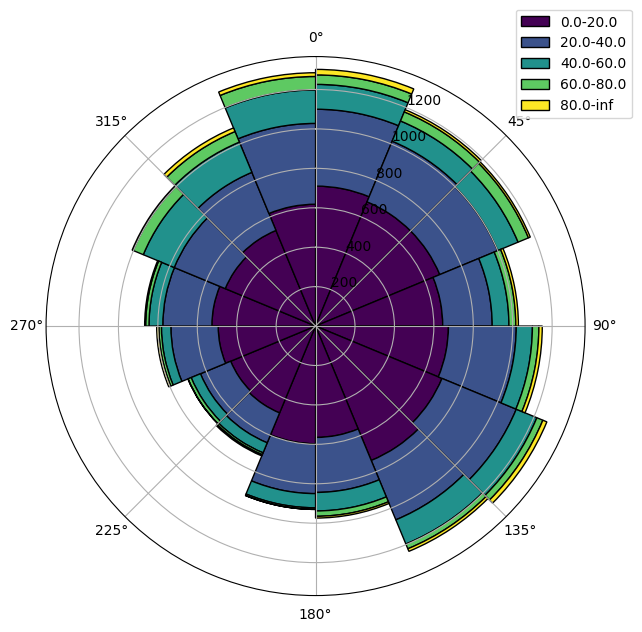

In [23]:
# Replace these with your actual data arrays
directions = df_tilt_data['Tilt Dir']
magnitudes = df_tilt_data['Tilt Dis']

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


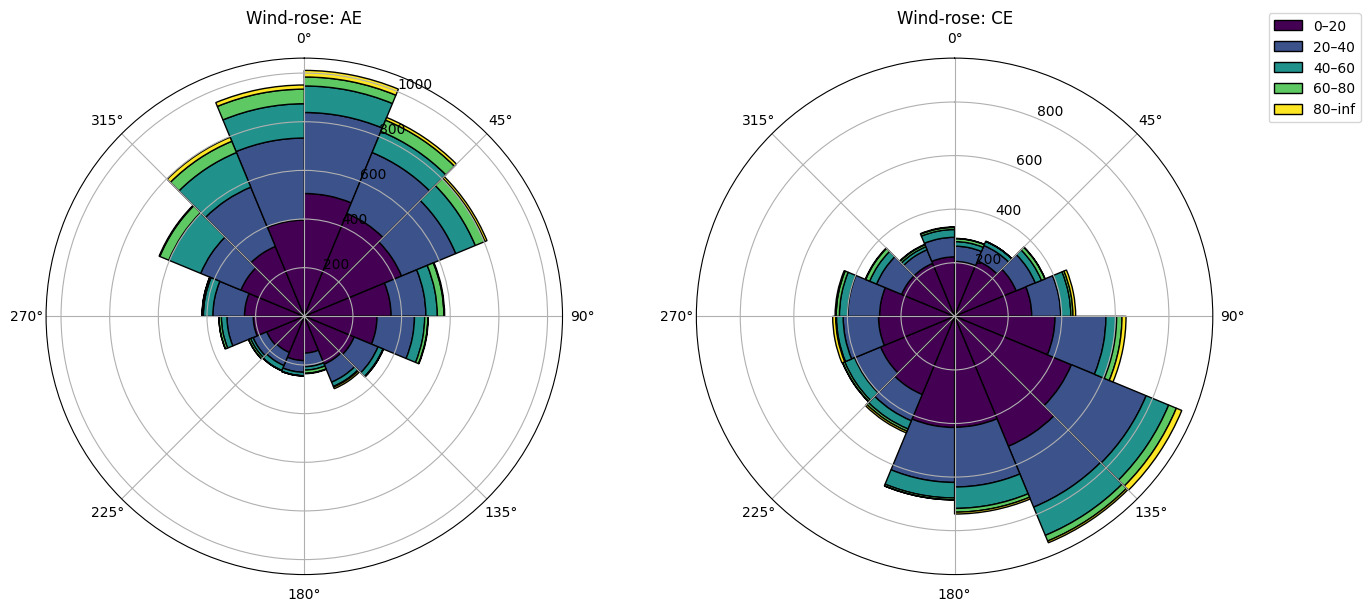

In [16]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

df_AE = df_tilt_data[df_tilt_data.Cyc=='AE'].copy()
df_CE = df_tilt_data[df_tilt_data.Cyc=='CE'].copy()

for ax, (df, title) in zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')]):
    directions = df['Tilt Dir']
    magnitudes = df['Tilt Dis']

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f'Wind‑rose: {title}')

# One legend for both
axs[-1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()
